In [ ]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [ ]:
data=pd.read_csv('/content/bicoin_data.csv')
data.head()

,Unnamed: 0,datetime,open,high,low,close
0,0,2021-10-02 14:40:00,47893.92969,47981.64062,47889.07812,47981.64062
1,1,2021-10-02 14:45:00,47926.17188,47959.01172,47898.03125,47942.94141
2,2,2021-10-02 14:50:00,47956.17969,48095.00000,47950.66016,48095.00000
3,3,2021-10-02 14:55:00,48060.30859,48100.98828,48006.01172,48011.07812
4,4,2021-10-02 15:00:00,47966.01172,48015.01953,47952.35938,47957.01172


In [24]:
data.tail()

,datetime,open,high,low,close
datetime,,,,,
2021-10-19 23:40:00,2021-10-19 23:40:00,64385.80859,64422.01172,64349.23047,64416.00000
2021-10-19 23:45:00,2021-10-19 23:45:00,64449.39844,64449.39844,64333.98047,64366.60156
2021-10-19 23:50:00,2021-10-19 23:50:00,64393.57031,64393.57031,64218.80078,64235.23828
2021-10-19 23:55:00,2021-10-19 23:55:00,64257.71875,64276.12891,64196.96094,64275.53906
2021-10-20 00:00:00,2021-10-20 00:00:00,64268.39844,64342.85938,64238.05078,64250.01172


In [ ]:
data=data.iloc[:,1:]
data.index=data['datetime']

In [ ]:
# !st oreder we have to find making non stationary series to stationary
diff=data['close'].diff()
diff=diff.dropna()

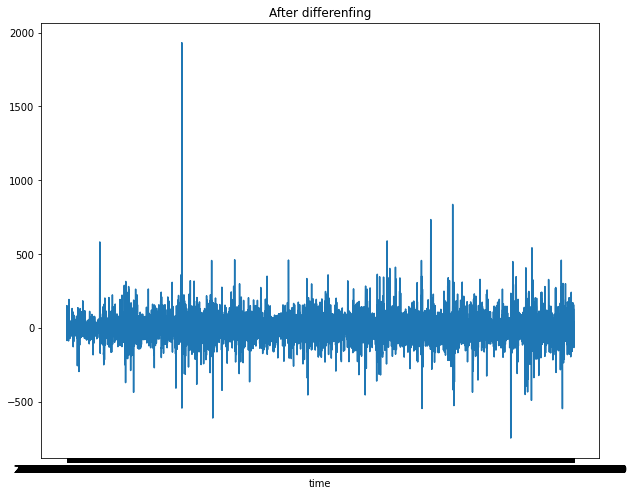

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(diff)
plt.title('After differenfing')
plt.xlabel('time')
plt.show()

In [53]:
#split train and test data
#we will test for last 4 days of data:-----<12*24*4=1152
test_len=1152
train=data['close'].values[:-test_len].astype('float32')
test=data['close'].values[len(train):].astype('float32')

In [65]:
train_data=data['close'][:-test_len]
test_data=data['close'][len(train):]

In [54]:
train.size

3848

In [55]:
test.size

1152

In [ ]:
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults
import itertools
from sklearn.metrics import mean_squared_error
def apply_arimax(train):
  comb=itertools.product(range(10),repeat=2)
  pq=list(comb)
  combs={}
  aics=[]
  d=1  #differencing order
  for p,q in pq:
    try:
      model=ARIMA(train,order=(p,d,q))
      result=model.fit(disp=0)
      combs.update({result.aic: [(p,d,q)]})
      aics.append(result.aic)
    except:
      continue
  best_aic=min(aics)
  order=combs[best_aic][0]
  print('ARIMA', order,'have minimum aic value ')
  return order

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import warnings
warnings.filterwarnings('ignore')
best_order=apply_arimax(train)


ARIMA (8, 1, 6) have minimum aic value 


In [38]:
#now we will fit into best _order
model=ARIMA(train,order=(8, 1, 6))
result=model.fit(disp=-1)

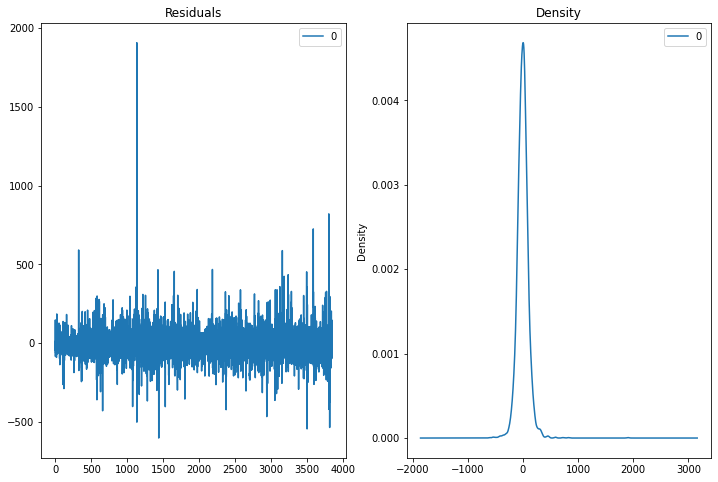

In [18]:
#visualized the residuals 
residuals = pd.DataFrame(result.resid)
fig, ax = plt.subplots(1,2,figsize=(12,8))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()       #they are like normal distribution curve so we can say errors are very less

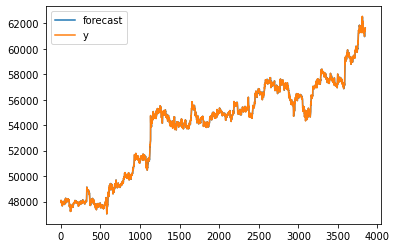

In [19]:
# Actual vs Fitted
result.plot_predict(dynamic=False)
plt.show()                #we can see our train data is performing welll

In [56]:
pred=result.predict()          #prediction of result

In [57]:
print('MSE for Training Data: ', np.sqrt(mean_squared_error(train,pred)))       #mean squared error for training data


MSE for Training Data:  54142.091706672254


In [60]:
fc, se, conf = result.forecast(len(test), alpha=0.05)                  #forecasting for 4 days

In [61]:
print('MSE for forasted data: ',np.sqrt(mean_squared_error(test,fc)))         #mean squared error for forecasted data

MSE for forasted data:  2080.722462760524


In [66]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)            #forecasted data
lower_series = pd.Series(conf[:, 0], index=test_data.index)  #lower price 
upper_series = pd.Series(conf[:, 1], index=test_data.index)   #upper price

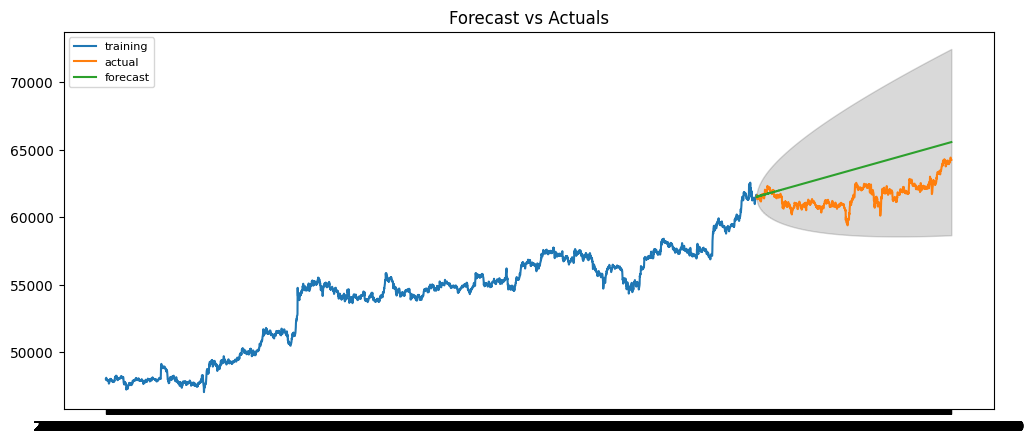

In [68]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

As we forecast our data of 4 days next by the previous data of 15 days and we have created lower and upper fluctuations . So we can say our model is predicting quit good.